In [1]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
%matplotlib inline

import numpy as np
np.random.seed(1)

import random
from skimage import io
import cv2
from keras.preprocessing.image import img_to_array
from vis.utils import utils
from vis.visualization import visualize_cam,visualize_saliency

from keras import backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import RMSprop, SGD

Using TensorFlow backend.


In [2]:
imagedir = "CG_Resized"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 8394
Label: 1	Family:            FOTO	Number of images: 8002
Processing images ...
Images processed: 16396


In [4]:
X.shape

(16396, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False)

In [7]:
filename = 'cg-resnet50features.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from cg-resnet50features.npy ...


In [8]:
resnet50features.shape

(16396, 1, 1, 2048)

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Training top_model and saving min training loss weights
num_epochs=2000
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
early_stopping = EarlyStopping(verbose=1, patience=20, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='cg-top-weights-min_loss-mlp-resnet50-Adam-2000epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
callbacks_list = [early_stopping, checkpointer]
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    Y_train = Y[train_indices]
    X_test = resnet50features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_input = Input(shape=resnet50features.shape[1:])
    x = GlobalAveragePooling2D(name='avg_pool')(top_input)
    predict = Dense(num_classes, activation='softmax', name='predictions')(x)
    top_model = Model(input=top_input, output=predict)                            
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=callbacks_list)
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 14755 samples, validate on 1641 samples
Epoch 1/2000
14755/14755 [==============================] - 0s - loss: 0.9461 - acc: 0.4666 - val_loss: 0.8302 - val_acc: 0.5820
Epoch 2/2000
14755/14755 [==============================] - 0s - loss: 0.8313 - acc: 0.5713 - val_loss: 0.7417 - val_acc: 0.6204
Epoch 3/2000
14755/14755 [==============================] - 0s - loss: 0.7414 - acc: 0.6162 - val_loss: 0.6506 - val_acc: 0.6563
Epoch 4/2000
14755/14755 [==============================] - 0s - loss: 0.6495 - acc: 0.6572 - val_loss: 0.5922 - val_acc: 0.6892
Epoch 5/2000
14755/14755 [==============================] - 0s - loss: 0.5906 - acc: 0.6897 - val_loss: 0.5412 - val_acc: 0.7331
Epoch 6/2000
14755/14755 [==============================] - 0s - loss: 0.5390 - acc: 0.7269 - val_loss: 0.4942 - val_acc: 0.7642
Epoch 7/2000
14755/14755 [==============================] - 0s - loss: 0.4911 - acc: 0.7608 - val_loss: 0.4584 - val_acc: 0.7879
Epoch 8/2000
14755/14755 [======================

14755/14755 [==============================] - 0s - loss: 0.1247 - acc: 0.9549 - val_loss: 0.1534 - val_acc: 0.9403
Epoch 126/2000
14755/14755 [==============================] - 0s - loss: 0.1243 - acc: 0.9551 - val_loss: 0.1532 - val_acc: 0.9403
Epoch 127/2000
14755/14755 [==============================] - 0s - loss: 0.1239 - acc: 0.9553 - val_loss: 0.1529 - val_acc: 0.9403
Epoch 128/2000
14755/14755 [==============================] - 0s - loss: 0.1234 - acc: 0.9556 - val_loss: 0.1527 - val_acc: 0.9403
Epoch 129/2000
14755/14755 [==============================] - 0s - loss: 0.1230 - acc: 0.9556 - val_loss: 0.1524 - val_acc: 0.9403
Epoch 130/2000
14755/14755 [==============================] - 0s - loss: 0.1226 - acc: 0.9559 - val_loss: 0.1522 - val_acc: 0.9403
Epoch 131/2000
14755/14755 [==============================] - 0s - loss: 0.1222 - acc: 0.9561 - val_loss: 0.1519 - val_acc: 0.9397
Epoch 132/2000
14755/14755 [==============================] - 0s - loss: 0.1218 - acc: 0.9563 - va

14755/14755 [==============================] - 0s - loss: 0.0915 - acc: 0.9702 - val_loss: 0.1368 - val_acc: 0.9445
Epoch 250/2000
14755/14755 [==============================] - 0s - loss: 0.0913 - acc: 0.9705 - val_loss: 0.1367 - val_acc: 0.9452
Epoch 251/2000
14755/14755 [==============================] - 0s - loss: 0.0911 - acc: 0.9706 - val_loss: 0.1367 - val_acc: 0.9452
Epoch 252/2000
14755/14755 [==============================] - 0s - loss: 0.0909 - acc: 0.9706 - val_loss: 0.1366 - val_acc: 0.9452
Epoch 253/2000
14755/14755 [==============================] - 0s - loss: 0.0908 - acc: 0.9706 - val_loss: 0.1366 - val_acc: 0.9452
Epoch 254/2000
14755/14755 [==============================] - 0s - loss: 0.0906 - acc: 0.9707 - val_loss: 0.1365 - val_acc: 0.9452
Epoch 255/2000
14755/14755 [==============================] - 0s - loss: 0.0904 - acc: 0.9707 - val_loss: 0.1364 - val_acc: 0.9452
Epoch 256/2000
14755/14755 [==============================] - 0s - loss: 0.0903 - acc: 0.9708 - va

14755/14755 [==============================] - 0s - loss: 0.0749 - acc: 0.9761 - val_loss: 0.1328 - val_acc: 0.9519
Epoch 374/2000
14755/14755 [==============================] - 0s - loss: 0.0748 - acc: 0.9761 - val_loss: 0.1328 - val_acc: 0.9519
Epoch 375/2000
14755/14755 [==============================] - 0s - loss: 0.0747 - acc: 0.9762 - val_loss: 0.1328 - val_acc: 0.9519
Epoch 376/2000
14755/14755 [==============================] - 0s - loss: 0.0746 - acc: 0.9762 - val_loss: 0.1328 - val_acc: 0.9525
Epoch 377/2000
14755/14755 [==============================] - 0s - loss: 0.0745 - acc: 0.9763 - val_loss: 0.1328 - val_acc: 0.9525
Epoch 378/2000
14755/14755 [==============================] - 0s - loss: 0.0744 - acc: 0.9763 - val_loss: 0.1328 - val_acc: 0.9525
Epoch 379/2000
14755/14755 [==============================] - 0s - loss: 0.0743 - acc: 0.9763 - val_loss: 0.1328 - val_acc: 0.9525
Epoch 380/2000
14755/14755 [==============================] - 0s - loss: 0.0742 - acc: 0.9763 - va

14755/14755 [==============================] - 0s - loss: 0.2369 - acc: 0.9063 - val_loss: 0.2201 - val_acc: 0.9104
Epoch 46/2000
14755/14755 [==============================] - 0s - loss: 0.2349 - acc: 0.9074 - val_loss: 0.2179 - val_acc: 0.9122
Epoch 47/2000
14755/14755 [==============================] - 0s - loss: 0.2328 - acc: 0.9088 - val_loss: 0.2157 - val_acc: 0.9147
Epoch 48/2000
14755/14755 [==============================] - 0s - loss: 0.2307 - acc: 0.9097 - val_loss: 0.2134 - val_acc: 0.9141
Epoch 49/2000
14755/14755 [==============================] - 0s - loss: 0.2285 - acc: 0.9113 - val_loss: 0.2112 - val_acc: 0.9165
Epoch 50/2000
14755/14755 [==============================] - 0s - loss: 0.2263 - acc: 0.9114 - val_loss: 0.2091 - val_acc: 0.9196
Epoch 51/2000
14755/14755 [==============================] - 0s - loss: 0.2243 - acc: 0.9118 - val_loss: 0.2073 - val_acc: 0.9214
Epoch 52/2000
14755/14755 [==============================] - 0s - loss: 0.2225 - acc: 0.9126 - val_loss:

14755/14755 [==============================] - 0s - loss: 0.1662 - acc: 0.9383 - val_loss: 0.1533 - val_acc: 0.9409
Epoch 109/2000
14755/14755 [==============================] - 0s - loss: 0.1655 - acc: 0.9387 - val_loss: 0.1528 - val_acc: 0.9409
Epoch 110/2000
14755/14755 [==============================] - 0s - loss: 0.1649 - acc: 0.9390 - val_loss: 0.1523 - val_acc: 0.9403
Epoch 111/2000
14755/14755 [==============================] - 0s - loss: 0.1644 - acc: 0.9394 - val_loss: 0.1519 - val_acc: 0.9409
Epoch 112/2000
14755/14755 [==============================] - 0s - loss: 0.1638 - acc: 0.9397 - val_loss: 0.1514 - val_acc: 0.9415
Epoch 113/2000
14755/14755 [==============================] - 0s - loss: 0.1632 - acc: 0.9400 - val_loss: 0.1509 - val_acc: 0.9421
Epoch 114/2000
14755/14755 [==============================] - 0s - loss: 0.1626 - acc: 0.9402 - val_loss: 0.1505 - val_acc: 0.9421
Epoch 115/2000
14755/14755 [==============================] - 0s - loss: 0.1621 - acc: 0.9406 - va

14755/14755 [==============================] - 0s - loss: 0.1215 - acc: 0.9561 - val_loss: 0.1207 - val_acc: 0.9512
Epoch 233/2000
14755/14755 [==============================] - 0s - loss: 0.1213 - acc: 0.9564 - val_loss: 0.1205 - val_acc: 0.9519
Epoch 234/2000
14755/14755 [==============================] - 0s - loss: 0.1211 - acc: 0.9566 - val_loss: 0.1204 - val_acc: 0.9519
Epoch 235/2000
14755/14755 [==============================] - 0s - loss: 0.1209 - acc: 0.9565 - val_loss: 0.1203 - val_acc: 0.9519
Epoch 236/2000
14755/14755 [==============================] - 0s - loss: 0.1206 - acc: 0.9566 - val_loss: 0.1201 - val_acc: 0.9519
Epoch 237/2000
14755/14755 [==============================] - 0s - loss: 0.1204 - acc: 0.9567 - val_loss: 0.1200 - val_acc: 0.9519
Epoch 238/2000
14755/14755 [==============================] - 0s - loss: 0.1202 - acc: 0.9570 - val_loss: 0.1198 - val_acc: 0.9519
Epoch 239/2000
14755/14755 [==============================] - 0s - loss: 0.1200 - acc: 0.9571 - va

14755/14755 [==============================] - 0s - loss: 0.1004 - acc: 0.9650 - val_loss: 0.1087 - val_acc: 0.9555
Epoch 357/2000
14755/14755 [==============================] - 0s - loss: 0.1003 - acc: 0.9650 - val_loss: 0.1086 - val_acc: 0.9555
Epoch 358/2000
14755/14755 [==============================] - 0s - loss: 0.1001 - acc: 0.9651 - val_loss: 0.1085 - val_acc: 0.9555
Epoch 359/2000
14755/14755 [==============================] - 0s - loss: 0.1000 - acc: 0.9652 - val_loss: 0.1085 - val_acc: 0.9555
Epoch 360/2000
14755/14755 [==============================] - 0s - loss: 0.0999 - acc: 0.9654 - val_loss: 0.1084 - val_acc: 0.9549
Epoch 361/2000
14755/14755 [==============================] - 0s - loss: 0.0998 - acc: 0.9654 - val_loss: 0.1084 - val_acc: 0.9549
Epoch 362/2000
14755/14755 [==============================] - 0s - loss: 0.0996 - acc: 0.9654 - val_loss: 0.1083 - val_acc: 0.9549
Epoch 363/2000
14755/14755 [==============================] - 0s - loss: 0.0995 - acc: 0.9654 - va

14755/14755 [==============================] - 0s - loss: 0.0870 - acc: 0.9702 - val_loss: 0.1025 - val_acc: 0.9604
Epoch 481/2000
14755/14755 [==============================] - 0s - loss: 0.0869 - acc: 0.9703 - val_loss: 0.1025 - val_acc: 0.9604
Epoch 482/2000
14755/14755 [==============================] - 0s - loss: 0.0868 - acc: 0.9705 - val_loss: 0.1024 - val_acc: 0.9604
Epoch 483/2000
14755/14755 [==============================] - 0s - loss: 0.0868 - acc: 0.9705 - val_loss: 0.1024 - val_acc: 0.9604
Epoch 484/2000
14755/14755 [==============================] - 0s - loss: 0.0867 - acc: 0.9705 - val_loss: 0.1024 - val_acc: 0.9604
Epoch 485/2000
14755/14755 [==============================] - 0s - loss: 0.0866 - acc: 0.9705 - val_loss: 0.1023 - val_acc: 0.9604
Epoch 486/2000
14755/14755 [==============================] - 0s - loss: 0.0865 - acc: 0.9705 - val_loss: 0.1023 - val_acc: 0.9604
Epoch 487/2000
14755/14755 [==============================] - 0s - loss: 0.0864 - acc: 0.9705 - va

14755/14755 [==============================] - 0s - loss: 0.0775 - acc: 0.9744 - val_loss: 0.0990 - val_acc: 0.9586
Epoch 605/2000
14755/14755 [==============================] - 0s - loss: 0.0774 - acc: 0.9744 - val_loss: 0.0990 - val_acc: 0.9586
Epoch 606/2000
14755/14755 [==============================] - 0s - loss: 0.0773 - acc: 0.9745 - val_loss: 0.0989 - val_acc: 0.9586
Epoch 607/2000
14755/14755 [==============================] - 0s - loss: 0.0773 - acc: 0.9746 - val_loss: 0.0989 - val_acc: 0.9586
Epoch 608/2000
14755/14755 [==============================] - 0s - loss: 0.0772 - acc: 0.9746 - val_loss: 0.0989 - val_acc: 0.9586
Epoch 609/2000
14755/14755 [==============================] - 0s - loss: 0.0772 - acc: 0.9746 - val_loss: 0.0989 - val_acc: 0.9586
Epoch 610/2000
14755/14755 [==============================] - 0s - loss: 0.0771 - acc: 0.9746 - val_loss: 0.0989 - val_acc: 0.9586
Epoch 611/2000
14755/14755 [==============================] - 0s - loss: 0.0770 - acc: 0.9746 - va

14755/14755 [==============================] - 0s - loss: 0.0702 - acc: 0.9778 - val_loss: 0.0971 - val_acc: 0.9598
Epoch 729/2000
14755/14755 [==============================] - 0s - loss: 0.0701 - acc: 0.9778 - val_loss: 0.0970 - val_acc: 0.9598
Epoch 730/2000
14755/14755 [==============================] - 0s - loss: 0.0701 - acc: 0.9778 - val_loss: 0.0970 - val_acc: 0.9598
Epoch 731/2000
14755/14755 [==============================] - 0s - loss: 0.0700 - acc: 0.9778 - val_loss: 0.0970 - val_acc: 0.9598
Epoch 732/2000
14755/14755 [==============================] - 0s - loss: 0.0700 - acc: 0.9778 - val_loss: 0.0970 - val_acc: 0.9598
Epoch 733/2000
14755/14755 [==============================] - 0s - loss: 0.0699 - acc: 0.9778 - val_loss: 0.0970 - val_acc: 0.9598
Epoch 734/2000
14755/14755 [==============================] - 0s - loss: 0.0699 - acc: 0.9778 - val_loss: 0.0970 - val_acc: 0.9598
Epoch 735/2000
14755/14755 [==============================] - 0s - loss: 0.0698 - acc: 0.9778 - va

14755/14755 [==============================] - 0s - loss: 0.0644 - acc: 0.9806 - val_loss: 0.0962 - val_acc: 0.9610
Epoch 853/2000
14755/14755 [==============================] - 0s - loss: 0.0643 - acc: 0.9808 - val_loss: 0.0962 - val_acc: 0.9610
Epoch 854/2000
14755/14755 [==============================] - 0s - loss: 0.0643 - acc: 0.9808 - val_loss: 0.0962 - val_acc: 0.9610
Epoch 855/2000
14755/14755 [==============================] - 0s - loss: 0.0642 - acc: 0.9808 - val_loss: 0.0962 - val_acc: 0.9610
Epoch 856/2000
14755/14755 [==============================] - 0s - loss: 0.0642 - acc: 0.9808 - val_loss: 0.0962 - val_acc: 0.9610
Epoch 857/2000
14755/14755 [==============================] - 0s - loss: 0.0642 - acc: 0.9808 - val_loss: 0.0962 - val_acc: 0.9610
Epoch 858/2000
14755/14755 [==============================] - 0s - loss: 0.0641 - acc: 0.9808 - val_loss: 0.0962 - val_acc: 0.9610
Epoch 859/2000
14755/14755 [==============================] - 0s - loss: 0.0641 - acc: 0.9808 - va

14756/14756 [==============================] - 0s - loss: 0.2313 - acc: 0.9069 - val_loss: 0.2263 - val_acc: 0.9024
Epoch 29/2000
14756/14756 [==============================] - 0s - loss: 0.2273 - acc: 0.9082 - val_loss: 0.2231 - val_acc: 0.9043
Epoch 30/2000
14756/14756 [==============================] - 0s - loss: 0.2237 - acc: 0.9103 - val_loss: 0.2198 - val_acc: 0.9067
Epoch 31/2000
14756/14756 [==============================] - 0s - loss: 0.2202 - acc: 0.9113 - val_loss: 0.2165 - val_acc: 0.9079
Epoch 32/2000
14756/14756 [==============================] - 0s - loss: 0.2168 - acc: 0.9122 - val_loss: 0.2132 - val_acc: 0.9122
Epoch 33/2000
14756/14756 [==============================] - 0s - loss: 0.2136 - acc: 0.9141 - val_loss: 0.2101 - val_acc: 0.9146
Epoch 34/2000
14756/14756 [==============================] - 0s - loss: 0.2106 - acc: 0.9156 - val_loss: 0.2073 - val_acc: 0.9165
Epoch 35/2000
14756/14756 [==============================] - 0s - loss: 0.2078 - acc: 0.9169 - val_loss:

14756/14756 [==============================] - 0s - loss: 0.1149 - acc: 0.9591 - val_loss: 0.1301 - val_acc: 0.9500
Epoch 154/2000
14756/14756 [==============================] - 0s - loss: 0.1146 - acc: 0.9591 - val_loss: 0.1299 - val_acc: 0.9506
Epoch 155/2000
14756/14756 [==============================] - 0s - loss: 0.1143 - acc: 0.9591 - val_loss: 0.1297 - val_acc: 0.9506
Epoch 156/2000
14756/14756 [==============================] - 0s - loss: 0.1140 - acc: 0.9591 - val_loss: 0.1295 - val_acc: 0.9506
Epoch 157/2000
14756/14756 [==============================] - 0s - loss: 0.1137 - acc: 0.9593 - val_loss: 0.1293 - val_acc: 0.9506
Epoch 158/2000
14756/14756 [==============================] - 0s - loss: 0.1134 - acc: 0.9593 - val_loss: 0.1291 - val_acc: 0.9506
Epoch 159/2000
14756/14756 [==============================] - 0s - loss: 0.1131 - acc: 0.9592 - val_loss: 0.1289 - val_acc: 0.9512
Epoch 160/2000
14756/14756 [==============================] - 0s - loss: 0.1128 - acc: 0.9593 - va

14756/14756 [==============================] - 0s - loss: 0.0885 - acc: 0.9690 - val_loss: 0.1154 - val_acc: 0.9555
Epoch 278/2000
14756/14756 [==============================] - 0s - loss: 0.0884 - acc: 0.9690 - val_loss: 0.1154 - val_acc: 0.9555
Epoch 279/2000
14756/14756 [==============================] - 0s - loss: 0.0882 - acc: 0.9690 - val_loss: 0.1153 - val_acc: 0.9555
Epoch 280/2000
14756/14756 [==============================] - 0s - loss: 0.0881 - acc: 0.9692 - val_loss: 0.1153 - val_acc: 0.9555
Epoch 281/2000
14756/14756 [==============================] - 0s - loss: 0.0880 - acc: 0.9694 - val_loss: 0.1152 - val_acc: 0.9555
Epoch 282/2000
14756/14756 [==============================] - 0s - loss: 0.0878 - acc: 0.9694 - val_loss: 0.1151 - val_acc: 0.9555
Epoch 283/2000
14756/14756 [==============================] - 0s - loss: 0.0877 - acc: 0.9695 - val_loss: 0.1151 - val_acc: 0.9555
Epoch 284/2000
14756/14756 [==============================] - 0s - loss: 0.0875 - acc: 0.9697 - va

14756/14756 [==============================] - 0s - loss: 0.0739 - acc: 0.9762 - val_loss: 0.1109 - val_acc: 0.9573
Epoch 402/2000
14756/14756 [==============================] - 0s - loss: 0.0738 - acc: 0.9762 - val_loss: 0.1109 - val_acc: 0.9573
Epoch 403/2000
14756/14756 [==============================] - 0s - loss: 0.0738 - acc: 0.9762 - val_loss: 0.1109 - val_acc: 0.9573
Epoch 404/2000
14756/14756 [==============================] - 0s - loss: 0.0737 - acc: 0.9763 - val_loss: 0.1109 - val_acc: 0.9573
Epoch 405/2000
14756/14756 [==============================] - 0s - loss: 0.0736 - acc: 0.9763 - val_loss: 0.1109 - val_acc: 0.9573
Epoch 406/2000
14756/14756 [==============================] - 0s - loss: 0.0735 - acc: 0.9763 - val_loss: 0.1109 - val_acc: 0.9573
Epoch 407/2000
14756/14756 [==============================] - 0s - loss: 0.0734 - acc: 0.9764 - val_loss: 0.1109 - val_acc: 0.9573
Epoch 408/2000
14756/14756 [==============================] - 0s - loss: 0.0733 - acc: 0.9764 - va

14756/14756 [==============================] - 0s - loss: 0.2592 - acc: 0.8914 - val_loss: 0.2465 - val_acc: 0.9018
Epoch 23/2000
14756/14756 [==============================] - 0s - loss: 0.2524 - acc: 0.8945 - val_loss: 0.2407 - val_acc: 0.9049
Epoch 24/2000
14756/14756 [==============================] - 0s - loss: 0.2462 - acc: 0.8973 - val_loss: 0.2355 - val_acc: 0.9061
Epoch 25/2000
14756/14756 [==============================] - 0s - loss: 0.2405 - acc: 0.9001 - val_loss: 0.2308 - val_acc: 0.9079
Epoch 26/2000
14756/14756 [==============================] - 0s - loss: 0.2352 - acc: 0.9026 - val_loss: 0.2266 - val_acc: 0.9079
Epoch 27/2000
14756/14756 [==============================] - 0s - loss: 0.2302 - acc: 0.9053 - val_loss: 0.2228 - val_acc: 0.9104
Epoch 28/2000
14756/14756 [==============================] - 0s - loss: 0.2256 - acc: 0.9077 - val_loss: 0.2193 - val_acc: 0.9122
Epoch 29/2000
14756/14756 [==============================] - 0s - loss: 0.2213 - acc: 0.9105 - val_loss:

14756/14756 [==============================] - 0s - loss: 0.1063 - acc: 0.9626 - val_loss: 0.1335 - val_acc: 0.9530
Epoch 148/2000
14756/14756 [==============================] - 0s - loss: 0.1060 - acc: 0.9626 - val_loss: 0.1333 - val_acc: 0.9530
Epoch 149/2000
14756/14756 [==============================] - 0s - loss: 0.1057 - acc: 0.9627 - val_loss: 0.1331 - val_acc: 0.9530
Epoch 150/2000
14756/14756 [==============================] - 0s - loss: 0.1054 - acc: 0.9630 - val_loss: 0.1330 - val_acc: 0.9530
Epoch 151/2000
14756/14756 [==============================] - 0s - loss: 0.1051 - acc: 0.9631 - val_loss: 0.1328 - val_acc: 0.9530
Epoch 152/2000
14756/14756 [==============================] - 0s - loss: 0.1047 - acc: 0.9630 - val_loss: 0.1326 - val_acc: 0.9530
Epoch 153/2000
14756/14756 [==============================] - 0s - loss: 0.1044 - acc: 0.9631 - val_loss: 0.1324 - val_acc: 0.9530
Epoch 154/2000
14756/14756 [==============================] - 0s - loss: 0.1041 - acc: 0.9631 - va

14756/14756 [==============================] - 0s - loss: 0.0796 - acc: 0.9734 - val_loss: 0.1208 - val_acc: 0.9579
Epoch 272/2000
14756/14756 [==============================] - 0s - loss: 0.0794 - acc: 0.9735 - val_loss: 0.1208 - val_acc: 0.9579
Epoch 273/2000
14756/14756 [==============================] - 0s - loss: 0.0793 - acc: 0.9735 - val_loss: 0.1207 - val_acc: 0.9579
Epoch 274/2000
14756/14756 [==============================] - 0s - loss: 0.0791 - acc: 0.9736 - val_loss: 0.1207 - val_acc: 0.9579
Epoch 275/2000
14756/14756 [==============================] - 0s - loss: 0.0790 - acc: 0.9736 - val_loss: 0.1207 - val_acc: 0.9579
Epoch 276/2000
14756/14756 [==============================] - 0s - loss: 0.0788 - acc: 0.9736 - val_loss: 0.1206 - val_acc: 0.9579
Epoch 277/2000
14756/14756 [==============================] - 0s - loss: 0.0787 - acc: 0.9737 - val_loss: 0.1206 - val_acc: 0.9579
Epoch 278/2000
14756/14756 [==============================] - 0s - loss: 0.0786 - acc: 0.9737 - va

14756/14756 [==============================] - 0s - loss: 0.0655 - acc: 0.9798 - val_loss: 0.1187 - val_acc: 0.9561
Epoch 396/2000
14756/14756 [==============================] - 0s - loss: 0.0655 - acc: 0.9798 - val_loss: 0.1187 - val_acc: 0.9561
Epoch 397/2000
14756/14756 [==============================] - 0s - loss: 0.0654 - acc: 0.9798 - val_loss: 0.1187 - val_acc: 0.9561
Epoch 398/2000
14756/14756 [==============================] - 0s - loss: 0.0653 - acc: 0.9798 - val_loss: 0.1187 - val_acc: 0.9561
Epoch 399/2000
14756/14756 [==============================] - 0s - loss: 0.0652 - acc: 0.9798 - val_loss: 0.1187 - val_acc: 0.9561
Epoch 400/2000
14756/14756 [==============================] - 0s - loss: 0.0651 - acc: 0.9799 - val_loss: 0.1187 - val_acc: 0.9561
Epoch 401/2000
14756/14756 [==============================] - 0s - loss: 0.0650 - acc: 0.9800 - val_loss: 0.1187 - val_acc: 0.9561
Epoch 402/2000
14756/14756 [==============================] - 0s - loss: 0.0649 - acc: 0.9803 - va

14757/14757 [==============================] - 0s - loss: 0.1299 - acc: 0.9512 - val_loss: 0.1486 - val_acc: 0.9451
Epoch 115/2000
14757/14757 [==============================] - 0s - loss: 0.1294 - acc: 0.9514 - val_loss: 0.1483 - val_acc: 0.9451
Epoch 116/2000
14757/14757 [==============================] - 0s - loss: 0.1290 - acc: 0.9514 - val_loss: 0.1480 - val_acc: 0.9451
Epoch 117/2000
14757/14757 [==============================] - 0s - loss: 0.1285 - acc: 0.9516 - val_loss: 0.1477 - val_acc: 0.9451
Epoch 118/2000
14757/14757 [==============================] - 0s - loss: 0.1281 - acc: 0.9518 - val_loss: 0.1474 - val_acc: 0.9451
Epoch 119/2000
14757/14757 [==============================] - 0s - loss: 0.1276 - acc: 0.9520 - val_loss: 0.1472 - val_acc: 0.9451
Epoch 120/2000
14757/14757 [==============================] - 0s - loss: 0.1271 - acc: 0.9522 - val_loss: 0.1469 - val_acc: 0.9451
Epoch 121/2000
14757/14757 [==============================] - 0s - loss: 0.1267 - acc: 0.9525 - va

14757/14757 [==============================] - 0s - loss: 0.0939 - acc: 0.9670 - val_loss: 0.1302 - val_acc: 0.9524
Epoch 239/2000
14757/14757 [==============================] - 0s - loss: 0.0937 - acc: 0.9671 - val_loss: 0.1301 - val_acc: 0.9518
Epoch 240/2000
14757/14757 [==============================] - 0s - loss: 0.0935 - acc: 0.9671 - val_loss: 0.1301 - val_acc: 0.9518
Epoch 241/2000
14757/14757 [==============================] - 0s - loss: 0.0933 - acc: 0.9673 - val_loss: 0.1300 - val_acc: 0.9518
Epoch 242/2000
14757/14757 [==============================] - 0s - loss: 0.0931 - acc: 0.9673 - val_loss: 0.1299 - val_acc: 0.9518
Epoch 243/2000
14757/14757 [==============================] - 0s - loss: 0.0930 - acc: 0.9673 - val_loss: 0.1298 - val_acc: 0.9518
Epoch 244/2000
14757/14757 [==============================] - 0s - loss: 0.0928 - acc: 0.9675 - val_loss: 0.1298 - val_acc: 0.9518
Epoch 245/2000
14757/14757 [==============================] - 0s - loss: 0.0926 - acc: 0.9676 - va

14757/14757 [==============================] - 0s - loss: 0.0768 - acc: 0.9747 - val_loss: 0.1248 - val_acc: 0.9512
Epoch 363/2000
14757/14757 [==============================] - 0s - loss: 0.0767 - acc: 0.9747 - val_loss: 0.1247 - val_acc: 0.9512
Epoch 364/2000
14757/14757 [==============================] - 0s - loss: 0.0766 - acc: 0.9747 - val_loss: 0.1247 - val_acc: 0.9512
Epoch 365/2000
14757/14757 [==============================] - 0s - loss: 0.0765 - acc: 0.9748 - val_loss: 0.1247 - val_acc: 0.9512
Epoch 366/2000
14757/14757 [==============================] - 0s - loss: 0.0764 - acc: 0.9748 - val_loss: 0.1247 - val_acc: 0.9512
Epoch 367/2000
14757/14757 [==============================] - 0s - loss: 0.0763 - acc: 0.9750 - val_loss: 0.1247 - val_acc: 0.9512
Epoch 368/2000
14757/14757 [==============================] - 0s - loss: 0.0762 - acc: 0.9751 - val_loss: 0.1246 - val_acc: 0.9512
Epoch 369/2000
14757/14757 [==============================] - 0s - loss: 0.0761 - acc: 0.9751 - va

14757/14757 [==============================] - 0s - loss: 0.0661 - acc: 0.9789 - val_loss: 0.1234 - val_acc: 0.9536
Epoch 487/2000
14757/14757 [==============================] - 0s - loss: 0.0660 - acc: 0.9790 - val_loss: 0.1234 - val_acc: 0.9536
Epoch 488/2000
14757/14757 [==============================] - 0s - loss: 0.0660 - acc: 0.9790 - val_loss: 0.1234 - val_acc: 0.9536
Epoch 489/2000
14757/14757 [==============================] - 0s - loss: 0.0659 - acc: 0.9790 - val_loss: 0.1234 - val_acc: 0.9536
Epoch 490/2000
14757/14757 [==============================] - 0s - loss: 0.0658 - acc: 0.9790 - val_loss: 0.1234 - val_acc: 0.9536
Epoch 491/2000
14757/14757 [==============================] - 0s - loss: 0.0657 - acc: 0.9791 - val_loss: 0.1234 - val_acc: 0.9536
Epoch 492/2000
14757/14757 [==============================] - 0s - loss: 0.0657 - acc: 0.9791 - val_loss: 0.1234 - val_acc: 0.9536
Epoch 493/2000
14757/14757 [==============================] - 0s - loss: 0.0656 - acc: 0.9791 - va

14757/14757 [==============================] - 0s - loss: 0.1390 - acc: 0.9487 - val_loss: 0.1582 - val_acc: 0.9347
Epoch 91/2000
14757/14757 [==============================] - 0s - loss: 0.1384 - acc: 0.9491 - val_loss: 0.1577 - val_acc: 0.9347
Epoch 92/2000
14757/14757 [==============================] - 0s - loss: 0.1378 - acc: 0.9494 - val_loss: 0.1573 - val_acc: 0.9347
Epoch 93/2000
14757/14757 [==============================] - 0s - loss: 0.1372 - acc: 0.9496 - val_loss: 0.1568 - val_acc: 0.9347
Epoch 94/2000
14757/14757 [==============================] - 0s - loss: 0.1366 - acc: 0.9497 - val_loss: 0.1564 - val_acc: 0.9347
Epoch 95/2000
14757/14757 [==============================] - 0s - loss: 0.1360 - acc: 0.9498 - val_loss: 0.1560 - val_acc: 0.9353
Epoch 96/2000
14757/14757 [==============================] - 0s - loss: 0.1355 - acc: 0.9503 - val_loss: 0.1555 - val_acc: 0.9353
Epoch 97/2000
14757/14757 [==============================] - 0s - loss: 0.1349 - acc: 0.9505 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.0967 - acc: 0.9661 - val_loss: 0.1304 - val_acc: 0.9463
Epoch 215/2000
14757/14757 [==============================] - 0s - loss: 0.0964 - acc: 0.9662 - val_loss: 0.1303 - val_acc: 0.9463
Epoch 216/2000
14757/14757 [==============================] - 0s - loss: 0.0962 - acc: 0.9665 - val_loss: 0.1302 - val_acc: 0.9469
Epoch 217/2000
14757/14757 [==============================] - 0s - loss: 0.0960 - acc: 0.9666 - val_loss: 0.1301 - val_acc: 0.9469
Epoch 218/2000
14757/14757 [==============================] - 0s - loss: 0.0958 - acc: 0.9667 - val_loss: 0.1300 - val_acc: 0.9469
Epoch 219/2000
14757/14757 [==============================] - 0s - loss: 0.0956 - acc: 0.9667 - val_loss: 0.1299 - val_acc: 0.9469
Epoch 220/2000
14757/14757 [==============================] - 0s - loss: 0.0955 - acc: 0.9667 - val_loss: 0.1298 - val_acc: 0.9469
Epoch 221/2000
14757/14757 [==============================] - 0s - loss: 0.0953 - acc: 0.9668 - va

14757/14757 [==============================] - 0s - loss: 0.0778 - acc: 0.9747 - val_loss: 0.1229 - val_acc: 0.9524
Epoch 339/2000
14757/14757 [==============================] - 0s - loss: 0.0777 - acc: 0.9747 - val_loss: 0.1229 - val_acc: 0.9524
Epoch 340/2000
14757/14757 [==============================] - 0s - loss: 0.0776 - acc: 0.9747 - val_loss: 0.1229 - val_acc: 0.9524
Epoch 341/2000
14757/14757 [==============================] - 0s - loss: 0.0775 - acc: 0.9747 - val_loss: 0.1229 - val_acc: 0.9524
Epoch 342/2000
14757/14757 [==============================] - 0s - loss: 0.0774 - acc: 0.9747 - val_loss: 0.1228 - val_acc: 0.9524
Epoch 343/2000
14757/14757 [==============================] - 0s - loss: 0.0773 - acc: 0.9748 - val_loss: 0.1228 - val_acc: 0.9524
Epoch 344/2000
14757/14757 [==============================] - 0s - loss: 0.0771 - acc: 0.9749 - val_loss: 0.1228 - val_acc: 0.9524
Epoch 345/2000
14757/14757 [==============================] - 0s - loss: 0.0770 - acc: 0.9749 - va

14757/14757 [==============================] - 0s - loss: 0.0662 - acc: 0.9787 - val_loss: 0.1215 - val_acc: 0.9500
Epoch 463/2000
14757/14757 [==============================] - 0s - loss: 0.0661 - acc: 0.9789 - val_loss: 0.1215 - val_acc: 0.9500
Epoch 464/2000
14757/14757 [==============================] - 0s - loss: 0.0661 - acc: 0.9789 - val_loss: 0.1215 - val_acc: 0.9500
Epoch 465/2000
14757/14757 [==============================] - 0s - loss: 0.0660 - acc: 0.9789 - val_loss: 0.1215 - val_acc: 0.9500
Epoch 466/2000
14757/14757 [==============================] - 0s - loss: 0.0659 - acc: 0.9789 - val_loss: 0.1215 - val_acc: 0.9500
Epoch 467/2000
14757/14757 [==============================] - 0s - loss: 0.0658 - acc: 0.9790 - val_loss: 0.1215 - val_acc: 0.9500
Epoch 468/2000
14757/14757 [==============================] - 0s - loss: 0.0658 - acc: 0.9791 - val_loss: 0.1215 - val_acc: 0.9500
Epoch 469/2000
14757/14757 [==============================] - 0s - loss: 0.0657 - acc: 0.9791 - va

14757/14757 [==============================] - 0s - loss: 0.1323 - acc: 0.9517 - val_loss: 0.1404 - val_acc: 0.9494
Epoch 113/2000
14757/14757 [==============================] - 0s - loss: 0.1318 - acc: 0.9518 - val_loss: 0.1400 - val_acc: 0.9500
Epoch 114/2000
14757/14757 [==============================] - 0s - loss: 0.1313 - acc: 0.9521 - val_loss: 0.1396 - val_acc: 0.9500
Epoch 115/2000
14757/14757 [==============================] - 0s - loss: 0.1309 - acc: 0.9522 - val_loss: 0.1392 - val_acc: 0.9506
Epoch 116/2000
14757/14757 [==============================] - 0s - loss: 0.1304 - acc: 0.9523 - val_loss: 0.1388 - val_acc: 0.9506
Epoch 117/2000
14757/14757 [==============================] - 0s - loss: 0.1300 - acc: 0.9524 - val_loss: 0.1384 - val_acc: 0.9506
Epoch 118/2000
14757/14757 [==============================] - 0s - loss: 0.1295 - acc: 0.9526 - val_loss: 0.1380 - val_acc: 0.9506
Epoch 119/2000
14757/14757 [==============================] - 0s - loss: 0.1291 - acc: 0.9528 - va

14757/14757 [==============================] - 0s - loss: 0.0965 - acc: 0.9678 - val_loss: 0.1121 - val_acc: 0.9591
Epoch 237/2000
14757/14757 [==============================] - 0s - loss: 0.0963 - acc: 0.9679 - val_loss: 0.1120 - val_acc: 0.9591
Epoch 238/2000
14757/14757 [==============================] - 0s - loss: 0.0961 - acc: 0.9679 - val_loss: 0.1119 - val_acc: 0.9591
Epoch 239/2000
14757/14757 [==============================] - 0s - loss: 0.0959 - acc: 0.9680 - val_loss: 0.1118 - val_acc: 0.9591
Epoch 240/2000
14757/14757 [==============================] - 0s - loss: 0.0957 - acc: 0.9680 - val_loss: 0.1117 - val_acc: 0.9591
Epoch 241/2000
14757/14757 [==============================] - 0s - loss: 0.0955 - acc: 0.9681 - val_loss: 0.1116 - val_acc: 0.9591
Epoch 242/2000
14757/14757 [==============================] - 0s - loss: 0.0954 - acc: 0.9682 - val_loss: 0.1114 - val_acc: 0.9597
Epoch 243/2000
14757/14757 [==============================] - 0s - loss: 0.0952 - acc: 0.9682 - va

14757/14757 [==============================] - 0s - loss: 0.0792 - acc: 0.9740 - val_loss: 0.1028 - val_acc: 0.9640
Epoch 361/2000
14757/14757 [==============================] - 0s - loss: 0.0791 - acc: 0.9740 - val_loss: 0.1028 - val_acc: 0.9640
Epoch 362/2000
14757/14757 [==============================] - 0s - loss: 0.0790 - acc: 0.9740 - val_loss: 0.1027 - val_acc: 0.9640
Epoch 363/2000
14757/14757 [==============================] - 0s - loss: 0.0789 - acc: 0.9742 - val_loss: 0.1027 - val_acc: 0.9646
Epoch 364/2000
14757/14757 [==============================] - 0s - loss: 0.0788 - acc: 0.9744 - val_loss: 0.1026 - val_acc: 0.9646
Epoch 365/2000
14757/14757 [==============================] - 0s - loss: 0.0787 - acc: 0.9744 - val_loss: 0.1026 - val_acc: 0.9646
Epoch 366/2000
14757/14757 [==============================] - 0s - loss: 0.0786 - acc: 0.9745 - val_loss: 0.1025 - val_acc: 0.9652
Epoch 367/2000
14757/14757 [==============================] - 0s - loss: 0.0785 - acc: 0.9745 - va

14757/14757 [==============================] - 0s - loss: 0.0683 - acc: 0.9787 - val_loss: 0.0993 - val_acc: 0.9664
Epoch 485/2000
14757/14757 [==============================] - 0s - loss: 0.0682 - acc: 0.9787 - val_loss: 0.0993 - val_acc: 0.9664
Epoch 486/2000
14757/14757 [==============================] - 0s - loss: 0.0682 - acc: 0.9787 - val_loss: 0.0993 - val_acc: 0.9658
Epoch 487/2000
14757/14757 [==============================] - 0s - loss: 0.0681 - acc: 0.9788 - val_loss: 0.0993 - val_acc: 0.9658
Epoch 488/2000
14757/14757 [==============================] - 0s - loss: 0.0680 - acc: 0.9788 - val_loss: 0.0993 - val_acc: 0.9658
Epoch 489/2000
14757/14757 [==============================] - 0s - loss: 0.0679 - acc: 0.9789 - val_loss: 0.0993 - val_acc: 0.9658
Epoch 490/2000
14757/14757 [==============================] - 0s - loss: 0.0679 - acc: 0.9789 - val_loss: 0.0993 - val_acc: 0.9658
Epoch 491/2000
14757/14757 [==============================] - 0s - loss: 0.0678 - acc: 0.9789 - va

14757/14757 [==============================] - 0s - loss: 0.0605 - acc: 0.9810 - val_loss: 0.0986 - val_acc: 0.9671
Epoch 609/2000
14757/14757 [==============================] - 0s - loss: 0.0605 - acc: 0.9811 - val_loss: 0.0986 - val_acc: 0.9671
Epoch 610/2000
14757/14757 [==============================] - 0s - loss: 0.0604 - acc: 0.9812 - val_loss: 0.0986 - val_acc: 0.9671
Epoch 611/2000
14757/14757 [==============================] - 0s - loss: 0.0603 - acc: 0.9812 - val_loss: 0.0986 - val_acc: 0.9671
Epoch 612/2000
14757/14757 [==============================] - 0s - loss: 0.0603 - acc: 0.9812 - val_loss: 0.0986 - val_acc: 0.9671
Epoch 613/2000
14757/14757 [==============================] - 0s - loss: 0.0602 - acc: 0.9812 - val_loss: 0.0986 - val_acc: 0.9671
Epoch 614/2000
14757/14757 [==============================] - 0s - loss: 0.0602 - acc: 0.9812 - val_loss: 0.0986 - val_acc: 0.9671
Epoch 615/2000
14757/14757 [==============================] - 0s - loss: 0.0601 - acc: 0.9813 - va

14757/14757 [==============================] - 0s - loss: 0.1304 - acc: 0.9522 - val_loss: 0.1631 - val_acc: 0.9426
Epoch 118/2000
14757/14757 [==============================] - 0s - loss: 0.1299 - acc: 0.9526 - val_loss: 0.1627 - val_acc: 0.9433
Epoch 119/2000
14757/14757 [==============================] - 0s - loss: 0.1295 - acc: 0.9527 - val_loss: 0.1623 - val_acc: 0.9439
Epoch 120/2000
14757/14757 [==============================] - 0s - loss: 0.1290 - acc: 0.9531 - val_loss: 0.1620 - val_acc: 0.9439
Epoch 121/2000
14757/14757 [==============================] - 0s - loss: 0.1286 - acc: 0.9532 - val_loss: 0.1616 - val_acc: 0.9445
Epoch 122/2000
14757/14757 [==============================] - 0s - loss: 0.1281 - acc: 0.9534 - val_loss: 0.1613 - val_acc: 0.9445
Epoch 123/2000
14757/14757 [==============================] - 0s - loss: 0.1277 - acc: 0.9536 - val_loss: 0.1609 - val_acc: 0.9445
Epoch 124/2000
14757/14757 [==============================] - 0s - loss: 0.1273 - acc: 0.9537 - va

14757/14757 [==============================] - 0s - loss: 0.0948 - acc: 0.9664 - val_loss: 0.1379 - val_acc: 0.9524
Epoch 242/2000
14757/14757 [==============================] - 0s - loss: 0.0946 - acc: 0.9665 - val_loss: 0.1378 - val_acc: 0.9524
Epoch 243/2000
14757/14757 [==============================] - 0s - loss: 0.0944 - acc: 0.9667 - val_loss: 0.1377 - val_acc: 0.9524
Epoch 244/2000
14757/14757 [==============================] - 0s - loss: 0.0943 - acc: 0.9667 - val_loss: 0.1376 - val_acc: 0.9530
Epoch 245/2000
14757/14757 [==============================] - 0s - loss: 0.0941 - acc: 0.9667 - val_loss: 0.1375 - val_acc: 0.9530
Epoch 246/2000
14757/14757 [==============================] - 0s - loss: 0.0939 - acc: 0.9667 - val_loss: 0.1374 - val_acc: 0.9524
Epoch 247/2000
14757/14757 [==============================] - 0s - loss: 0.0937 - acc: 0.9667 - val_loss: 0.1373 - val_acc: 0.9524
Epoch 248/2000
14757/14757 [==============================] - 0s - loss: 0.0935 - acc: 0.9668 - va

14757/14757 [==============================] - 0s - loss: 0.0775 - acc: 0.9743 - val_loss: 0.1305 - val_acc: 0.9561
Epoch 366/2000
14757/14757 [==============================] - 0s - loss: 0.0774 - acc: 0.9744 - val_loss: 0.1305 - val_acc: 0.9561
Epoch 367/2000
14757/14757 [==============================] - 0s - loss: 0.0773 - acc: 0.9744 - val_loss: 0.1305 - val_acc: 0.9561
Epoch 368/2000
14757/14757 [==============================] - 0s - loss: 0.0772 - acc: 0.9745 - val_loss: 0.1304 - val_acc: 0.9561
Epoch 369/2000
14757/14757 [==============================] - 0s - loss: 0.0770 - acc: 0.9745 - val_loss: 0.1304 - val_acc: 0.9555
Epoch 370/2000
14757/14757 [==============================] - 0s - loss: 0.0769 - acc: 0.9745 - val_loss: 0.1304 - val_acc: 0.9555
Epoch 371/2000
14757/14757 [==============================] - 0s - loss: 0.0768 - acc: 0.9746 - val_loss: 0.1303 - val_acc: 0.9555
Epoch 372/2000
14757/14757 [==============================] - 0s - loss: 0.0767 - acc: 0.9746 - va

14757/14757 [==============================] - 0s - loss: 0.0666 - acc: 0.9798 - val_loss: 0.1290 - val_acc: 0.9536
Epoch 490/2000
14757/14757 [==============================] - 0s - loss: 0.0665 - acc: 0.9798 - val_loss: 0.1290 - val_acc: 0.9536
Epoch 491/2000
14757/14757 [==============================] - 0s - loss: 0.0664 - acc: 0.9798 - val_loss: 0.1290 - val_acc: 0.9536
Epoch 492/2000
14757/14757 [==============================] - 0s - loss: 0.0664 - acc: 0.9799 - val_loss: 0.1290 - val_acc: 0.9536
Epoch 493/2000
14757/14757 [==============================] - 0s - loss: 0.0663 - acc: 0.9800 - val_loss: 0.1290 - val_acc: 0.9536
Epoch 494/2000
14757/14757 [==============================] - 0s - loss: 0.0662 - acc: 0.9800 - val_loss: 0.1290 - val_acc: 0.9536
Epoch 495/2000
14757/14757 [==============================] - 0s - loss: 0.0661 - acc: 0.9801 - val_loss: 0.1290 - val_acc: 0.9536
Epoch 496/2000
14757/14757 [==============================] - 0s - loss: 0.0661 - acc: 0.9801 - va

14757/14757 [==============================] - 0s - loss: 0.1683 - acc: 0.9358 - val_loss: 0.1972 - val_acc: 0.9207
Epoch 110/2000
14757/14757 [==============================] - 0s - loss: 0.1677 - acc: 0.9359 - val_loss: 0.1966 - val_acc: 0.9207
Epoch 111/2000
14757/14757 [==============================] - 0s - loss: 0.1671 - acc: 0.9361 - val_loss: 0.1960 - val_acc: 0.9207
Epoch 112/2000
14757/14757 [==============================] - 0s - loss: 0.1665 - acc: 0.9362 - val_loss: 0.1954 - val_acc: 0.9213
Epoch 113/2000
14757/14757 [==============================] - 0s - loss: 0.1659 - acc: 0.9362 - val_loss: 0.1949 - val_acc: 0.9213
Epoch 114/2000
14757/14757 [==============================] - 0s - loss: 0.1653 - acc: 0.9365 - val_loss: 0.1943 - val_acc: 0.9219
Epoch 115/2000
14757/14757 [==============================] - 0s - loss: 0.1647 - acc: 0.9368 - val_loss: 0.1938 - val_acc: 0.9219
Epoch 116/2000
14757/14757 [==============================] - 0s - loss: 0.1641 - acc: 0.9372 - va

14757/14757 [==============================] - 0s - loss: 0.1229 - acc: 0.9547 - val_loss: 0.1568 - val_acc: 0.9353
Epoch 234/2000
14757/14757 [==============================] - 0s - loss: 0.1226 - acc: 0.9548 - val_loss: 0.1566 - val_acc: 0.9353
Epoch 235/2000
14757/14757 [==============================] - 0s - loss: 0.1224 - acc: 0.9549 - val_loss: 0.1564 - val_acc: 0.9353
Epoch 236/2000
14757/14757 [==============================] - 0s - loss: 0.1222 - acc: 0.9549 - val_loss: 0.1563 - val_acc: 0.9353
Epoch 237/2000
14757/14757 [==============================] - 0s - loss: 0.1220 - acc: 0.9550 - val_loss: 0.1561 - val_acc: 0.9353
Epoch 238/2000
14757/14757 [==============================] - 0s - loss: 0.1217 - acc: 0.9551 - val_loss: 0.1559 - val_acc: 0.9353
Epoch 239/2000
14757/14757 [==============================] - 0s - loss: 0.1215 - acc: 0.9551 - val_loss: 0.1557 - val_acc: 0.9353
Epoch 240/2000
14757/14757 [==============================] - 0s - loss: 0.1213 - acc: 0.9553 - va

14757/14757 [==============================] - 0s - loss: 0.1017 - acc: 0.9637 - val_loss: 0.1411 - val_acc: 0.9426
Epoch 358/2000
14757/14757 [==============================] - 0s - loss: 0.1016 - acc: 0.9637 - val_loss: 0.1410 - val_acc: 0.9426
Epoch 359/2000
14757/14757 [==============================] - 0s - loss: 0.1015 - acc: 0.9637 - val_loss: 0.1409 - val_acc: 0.9426
Epoch 360/2000
14757/14757 [==============================] - 0s - loss: 0.1014 - acc: 0.9637 - val_loss: 0.1408 - val_acc: 0.9426
Epoch 361/2000
14757/14757 [==============================] - 0s - loss: 0.1012 - acc: 0.9637 - val_loss: 0.1408 - val_acc: 0.9433
Epoch 362/2000
14757/14757 [==============================] - 0s - loss: 0.1011 - acc: 0.9639 - val_loss: 0.1407 - val_acc: 0.9433
Epoch 363/2000
14757/14757 [==============================] - 0s - loss: 0.1010 - acc: 0.9640 - val_loss: 0.1406 - val_acc: 0.9433
Epoch 364/2000
14757/14757 [==============================] - 0s - loss: 0.1008 - acc: 0.9641 - va

14757/14757 [==============================] - 0s - loss: 0.0885 - acc: 0.9697 - val_loss: 0.1331 - val_acc: 0.9487
Epoch 482/2000
14757/14757 [==============================] - 0s - loss: 0.0884 - acc: 0.9697 - val_loss: 0.1330 - val_acc: 0.9487
Epoch 483/2000
14757/14757 [==============================] - 0s - loss: 0.0883 - acc: 0.9698 - val_loss: 0.1330 - val_acc: 0.9487
Epoch 484/2000
14757/14757 [==============================] - 0s - loss: 0.0882 - acc: 0.9699 - val_loss: 0.1329 - val_acc: 0.9487
Epoch 485/2000
14757/14757 [==============================] - 0s - loss: 0.0881 - acc: 0.9699 - val_loss: 0.1329 - val_acc: 0.9487
Epoch 486/2000
14757/14757 [==============================] - 0s - loss: 0.0880 - acc: 0.9700 - val_loss: 0.1328 - val_acc: 0.9487
Epoch 487/2000
14757/14757 [==============================] - 0s - loss: 0.0880 - acc: 0.9700 - val_loss: 0.1328 - val_acc: 0.9487
Epoch 488/2000
14757/14757 [==============================] - 0s - loss: 0.0879 - acc: 0.9700 - va

14757/14757 [==============================] - 0s - loss: 0.0790 - acc: 0.9739 - val_loss: 0.1286 - val_acc: 0.9506
Epoch 606/2000
14757/14757 [==============================] - 0s - loss: 0.0790 - acc: 0.9740 - val_loss: 0.1285 - val_acc: 0.9506
Epoch 607/2000
14757/14757 [==============================] - 0s - loss: 0.0789 - acc: 0.9740 - val_loss: 0.1285 - val_acc: 0.9506
Epoch 608/2000
14757/14757 [==============================] - 0s - loss: 0.0788 - acc: 0.9740 - val_loss: 0.1285 - val_acc: 0.9506
Epoch 609/2000
14757/14757 [==============================] - 0s - loss: 0.0788 - acc: 0.9740 - val_loss: 0.1285 - val_acc: 0.9506
Epoch 610/2000
14757/14757 [==============================] - 0s - loss: 0.0787 - acc: 0.9740 - val_loss: 0.1284 - val_acc: 0.9506
Epoch 611/2000
14757/14757 [==============================] - 0s - loss: 0.0786 - acc: 0.9740 - val_loss: 0.1284 - val_acc: 0.9506
Epoch 612/2000
14757/14757 [==============================] - 0s - loss: 0.0786 - acc: 0.9740 - va

14757/14757 [==============================] - 0s - loss: 0.0718 - acc: 0.9767 - val_loss: 0.1260 - val_acc: 0.9506
Epoch 730/2000
14757/14757 [==============================] - 0s - loss: 0.0717 - acc: 0.9767 - val_loss: 0.1260 - val_acc: 0.9506
Epoch 731/2000
14757/14757 [==============================] - 0s - loss: 0.0717 - acc: 0.9767 - val_loss: 0.1260 - val_acc: 0.9506
Epoch 732/2000
14757/14757 [==============================] - 0s - loss: 0.0716 - acc: 0.9767 - val_loss: 0.1259 - val_acc: 0.9506
Epoch 733/2000
14757/14757 [==============================] - 0s - loss: 0.0716 - acc: 0.9767 - val_loss: 0.1259 - val_acc: 0.9506
Epoch 734/2000
14757/14757 [==============================] - 0s - loss: 0.0715 - acc: 0.9768 - val_loss: 0.1259 - val_acc: 0.9506
Epoch 735/2000
14757/14757 [==============================] - 0s - loss: 0.0715 - acc: 0.9768 - val_loss: 0.1259 - val_acc: 0.9506
Epoch 736/2000
14757/14757 [==============================] - 0s - loss: 0.0714 - acc: 0.9769 - va

14757/14757 [==============================] - 0s - loss: 0.0660 - acc: 0.9794 - val_loss: 0.1246 - val_acc: 0.9506
Epoch 854/2000
14757/14757 [==============================] - 0s - loss: 0.0659 - acc: 0.9795 - val_loss: 0.1246 - val_acc: 0.9506
Epoch 855/2000
14757/14757 [==============================] - 0s - loss: 0.0659 - acc: 0.9795 - val_loss: 0.1246 - val_acc: 0.9506
Epoch 856/2000
14757/14757 [==============================] - 0s - loss: 0.0658 - acc: 0.9795 - val_loss: 0.1246 - val_acc: 0.9506
Epoch 857/2000
14757/14757 [==============================] - 0s - loss: 0.0658 - acc: 0.9795 - val_loss: 0.1246 - val_acc: 0.9506
Epoch 858/2000
14757/14757 [==============================] - 0s - loss: 0.0658 - acc: 0.9795 - val_loss: 0.1246 - val_acc: 0.9506
Epoch 859/2000
14757/14757 [==============================] - 0s - loss: 0.0657 - acc: 0.9795 - val_loss: 0.1246 - val_acc: 0.9506
Epoch 860/2000
14757/14757 [==============================] - 0s - loss: 0.0657 - acc: 0.9796 - va

14757/14757 [==============================] - 0s - loss: 0.0611 - acc: 0.9813 - val_loss: 0.1242 - val_acc: 0.9500
Epoch 978/2000
14757/14757 [==============================] - 0s - loss: 0.0611 - acc: 0.9814 - val_loss: 0.1242 - val_acc: 0.9500
Epoch 979/2000
14757/14757 [==============================] - 0s - loss: 0.0611 - acc: 0.9814 - val_loss: 0.1242 - val_acc: 0.9500
Epoch 980/2000
14757/14757 [==============================] - 0s - loss: 0.0610 - acc: 0.9814 - val_loss: 0.1242 - val_acc: 0.9500
Epoch 981/2000
14757/14757 [==============================] - 0s - loss: 0.0610 - acc: 0.9814 - val_loss: 0.1242 - val_acc: 0.9500
Epoch 982/2000
14757/14757 [==============================] - 0s - loss: 0.0610 - acc: 0.9814 - val_loss: 0.1242 - val_acc: 0.9500
Epoch 983/2000
14757/14757 [==============================] - 0s - loss: 0.0609 - acc: 0.9814 - val_loss: 0.1242 - val_acc: 0.9500
Epoch 984/2000
14757/14757 [==============================] - 0s - loss: 0.0609 - acc: 0.9814 - va

14757/14757 [==============================] - 0s - loss: 0.1661 - acc: 0.9410 - val_loss: 0.1784 - val_acc: 0.9243
Epoch 83/2000
14757/14757 [==============================] - 0s - loss: 0.1653 - acc: 0.9414 - val_loss: 0.1777 - val_acc: 0.9243
Epoch 84/2000
14757/14757 [==============================] - 0s - loss: 0.1645 - acc: 0.9416 - val_loss: 0.1770 - val_acc: 0.9237
Epoch 85/2000
14757/14757 [==============================] - 0s - loss: 0.1638 - acc: 0.9422 - val_loss: 0.1763 - val_acc: 0.9243
Epoch 86/2000
14757/14757 [==============================] - 0s - loss: 0.1630 - acc: 0.9424 - val_loss: 0.1756 - val_acc: 0.9243
Epoch 87/2000
14757/14757 [==============================] - 0s - loss: 0.1623 - acc: 0.9424 - val_loss: 0.1750 - val_acc: 0.9250
Epoch 88/2000
14757/14757 [==============================] - 0s - loss: 0.1616 - acc: 0.9424 - val_loss: 0.1743 - val_acc: 0.9256
Epoch 89/2000
14757/14757 [==============================] - 0s - loss: 0.1609 - acc: 0.9426 - val_loss:

14757/14757 [==============================] - 0s - loss: 0.1153 - acc: 0.9594 - val_loss: 0.1380 - val_acc: 0.9445
Epoch 207/2000
14757/14757 [==============================] - 0s - loss: 0.1150 - acc: 0.9593 - val_loss: 0.1378 - val_acc: 0.9445
Epoch 208/2000
14757/14757 [==============================] - 0s - loss: 0.1148 - acc: 0.9595 - val_loss: 0.1377 - val_acc: 0.9445
Epoch 209/2000
14757/14757 [==============================] - 0s - loss: 0.1146 - acc: 0.9595 - val_loss: 0.1375 - val_acc: 0.9445
Epoch 210/2000
14757/14757 [==============================] - 0s - loss: 0.1143 - acc: 0.9597 - val_loss: 0.1374 - val_acc: 0.9445
Epoch 211/2000
14757/14757 [==============================] - 0s - loss: 0.1141 - acc: 0.9597 - val_loss: 0.1372 - val_acc: 0.9451
Epoch 212/2000
14757/14757 [==============================] - 0s - loss: 0.1139 - acc: 0.9599 - val_loss: 0.1371 - val_acc: 0.9457
Epoch 213/2000
14757/14757 [==============================] - 0s - loss: 0.1137 - acc: 0.9600 - va

14757/14757 [==============================] - 0s - loss: 0.0936 - acc: 0.9684 - val_loss: 0.1258 - val_acc: 0.9506
Epoch 331/2000
14757/14757 [==============================] - 0s - loss: 0.0934 - acc: 0.9684 - val_loss: 0.1257 - val_acc: 0.9506
Epoch 332/2000
14757/14757 [==============================] - 0s - loss: 0.0933 - acc: 0.9686 - val_loss: 0.1257 - val_acc: 0.9506
Epoch 333/2000
14757/14757 [==============================] - 0s - loss: 0.0932 - acc: 0.9686 - val_loss: 0.1256 - val_acc: 0.9506
Epoch 334/2000
14757/14757 [==============================] - 0s - loss: 0.0930 - acc: 0.9686 - val_loss: 0.1255 - val_acc: 0.9506
Epoch 335/2000
14757/14757 [==============================] - 0s - loss: 0.0929 - acc: 0.9686 - val_loss: 0.1255 - val_acc: 0.9506
Epoch 336/2000
14757/14757 [==============================] - 0s - loss: 0.0928 - acc: 0.9688 - val_loss: 0.1254 - val_acc: 0.9506
Epoch 337/2000
14757/14757 [==============================] - 0s - loss: 0.0926 - acc: 0.9690 - va

14757/14757 [==============================] - 0s - loss: 0.0802 - acc: 0.9737 - val_loss: 0.1205 - val_acc: 0.9530
Epoch 455/2000
14757/14757 [==============================] - 0s - loss: 0.0801 - acc: 0.9737 - val_loss: 0.1204 - val_acc: 0.9530
Epoch 456/2000
14757/14757 [==============================] - 0s - loss: 0.0800 - acc: 0.9737 - val_loss: 0.1204 - val_acc: 0.9530
Epoch 457/2000
14757/14757 [==============================] - 0s - loss: 0.0799 - acc: 0.9738 - val_loss: 0.1204 - val_acc: 0.9530
Epoch 458/2000
14757/14757 [==============================] - 0s - loss: 0.0799 - acc: 0.9738 - val_loss: 0.1203 - val_acc: 0.9530
Epoch 459/2000
14757/14757 [==============================] - 0s - loss: 0.0798 - acc: 0.9738 - val_loss: 0.1203 - val_acc: 0.9530
Epoch 460/2000
14757/14757 [==============================] - 0s - loss: 0.0797 - acc: 0.9738 - val_loss: 0.1203 - val_acc: 0.9530
Epoch 461/2000
14757/14757 [==============================] - 0s - loss: 0.0796 - acc: 0.9739 - va

14757/14757 [==============================] - 0s - loss: 0.0708 - acc: 0.9780 - val_loss: 0.1182 - val_acc: 0.9549
Epoch 579/2000
14757/14757 [==============================] - 0s - loss: 0.0708 - acc: 0.9780 - val_loss: 0.1182 - val_acc: 0.9549
Epoch 580/2000
14757/14757 [==============================] - 0s - loss: 0.0707 - acc: 0.9780 - val_loss: 0.1182 - val_acc: 0.9549
Epoch 581/2000
14757/14757 [==============================] - 0s - loss: 0.0706 - acc: 0.9780 - val_loss: 0.1182 - val_acc: 0.9549
Epoch 582/2000
14757/14757 [==============================] - 0s - loss: 0.0706 - acc: 0.9780 - val_loss: 0.1182 - val_acc: 0.9549
Epoch 583/2000
14757/14757 [==============================] - 0s - loss: 0.0705 - acc: 0.9780 - val_loss: 0.1182 - val_acc: 0.9549
Epoch 584/2000
14757/14757 [==============================] - 0s - loss: 0.0704 - acc: 0.9780 - val_loss: 0.1182 - val_acc: 0.9549
Epoch 585/2000
14757/14757 [==============================] - 0s - loss: 0.0704 - acc: 0.9780 - va

14757/14757 [==============================] - 0s - loss: 0.0637 - acc: 0.9808 - val_loss: 0.1177 - val_acc: 0.9561
Epoch 703/2000
14757/14757 [==============================] - 0s - loss: 0.0637 - acc: 0.9808 - val_loss: 0.1177 - val_acc: 0.9561
Epoch 00702: early stopping
[9] Test acurracy: 0.9561


In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9555


In [12]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [13]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

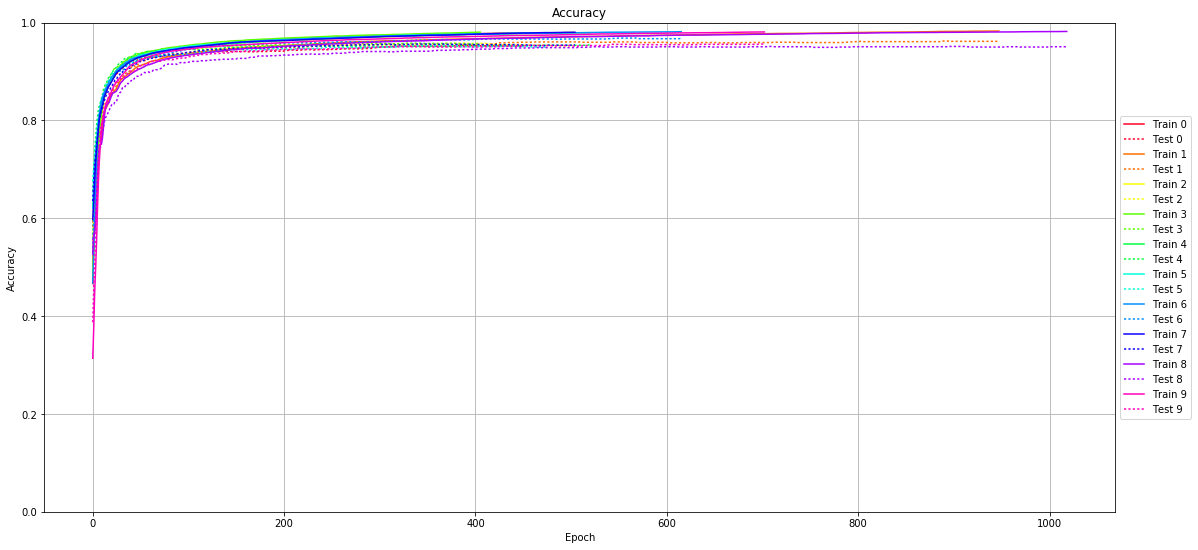

In [14]:
plot_acc(history)

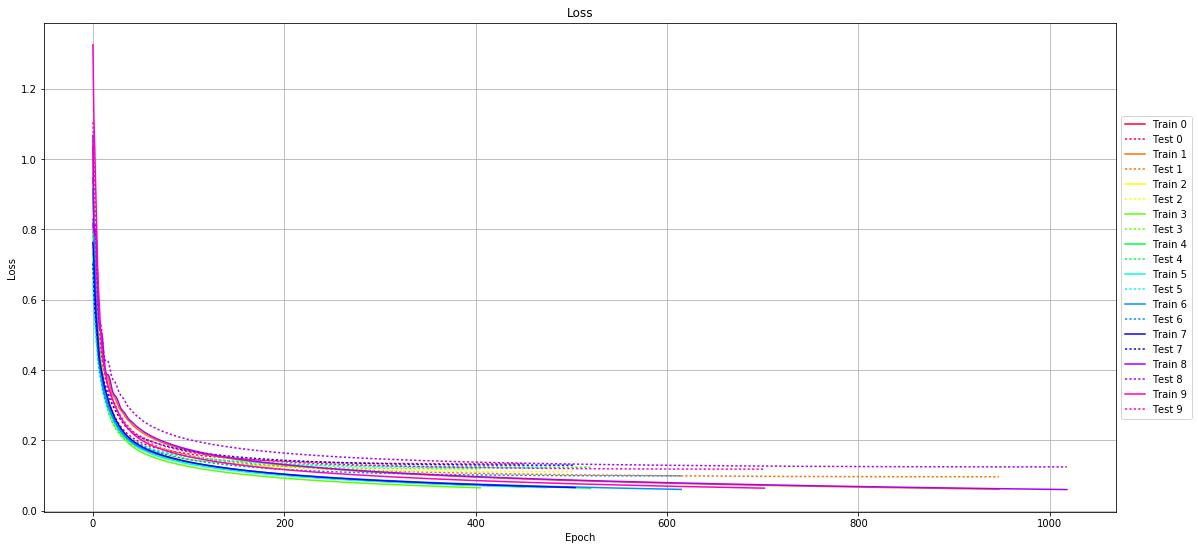

In [15]:
plot_loss(history)

In [16]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


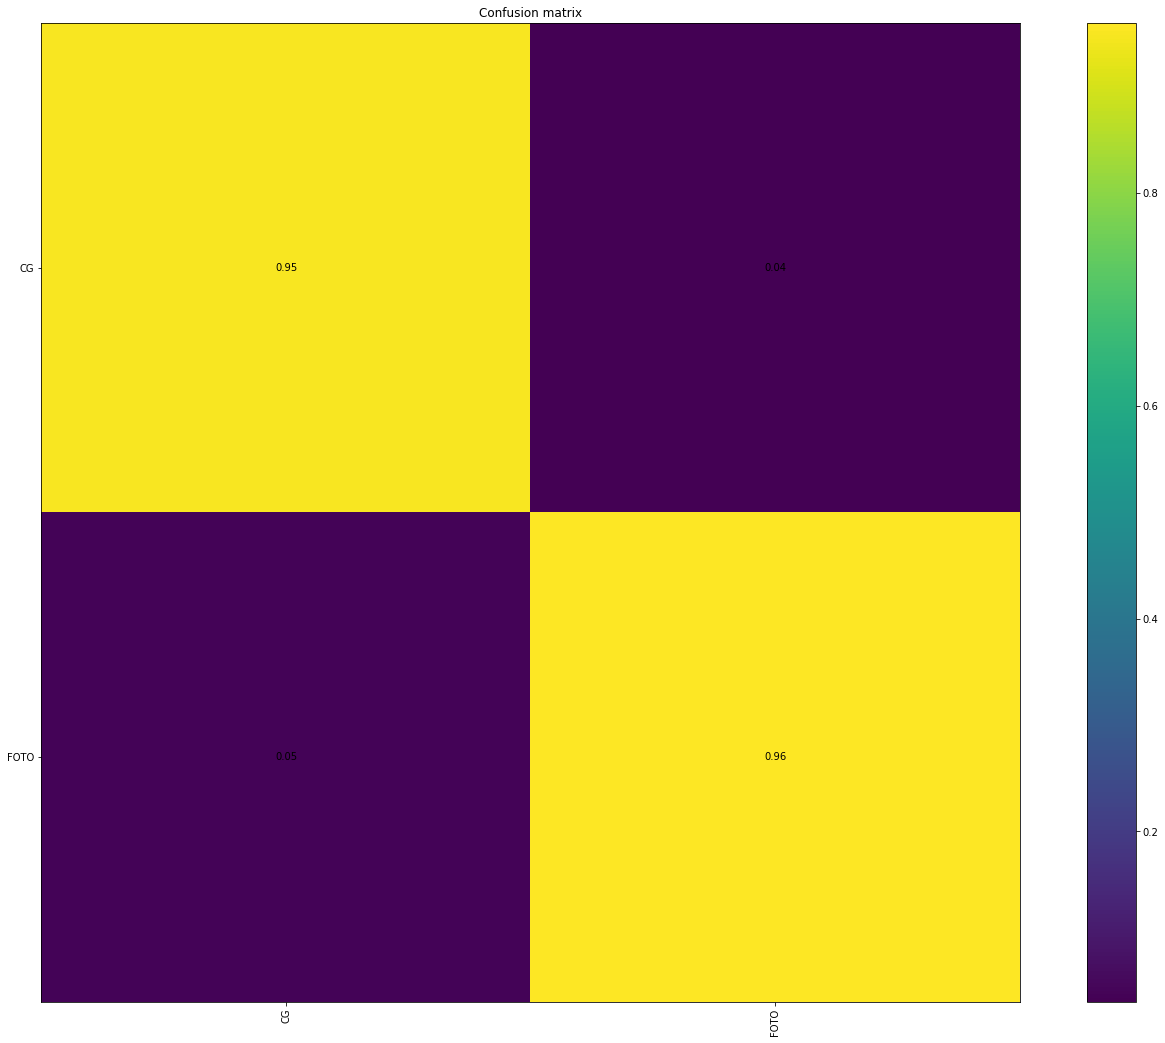

In [17]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()